# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Import data and visualize

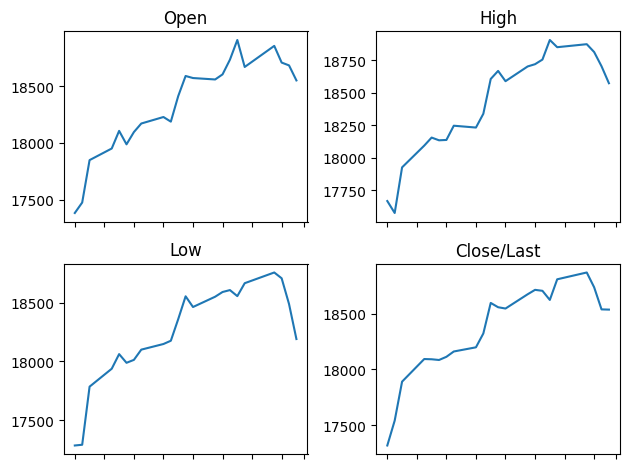

In [6]:
df = pd.read_csv(r"dataset\NASDAQ100_1month.csv")
#df = pd.read_csv(r"dataset\NASDAQ100_6month.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

figure, axis = plt.subplots(2, 2)

axis[0,0].plot(df['Date'], df['Open'])
axis[0,0].set_title("Open")
axis[0,0].set_xticklabels([])

axis[0,1].plot(df['Date'], df['High'])
axis[0,1].set_title("High")
axis[0,1].set_xticklabels([])

axis[1,0].plot(df['Date'], df['Low'])
axis[1,0].set_title("Low")
axis[1,0].set_xticklabels([])

axis[1,1].plot(df['Date'], df['Close/Last'])
axis[1,1].set_title("Close/Last")
axis[1,1].set_xticklabels([])

plt.tight_layout()
plt.show()